# **Identifikation von Problemstellen in Java-Anwedungen**


In [1]:
#Graphdatenbankanbindung
import py2neo

graph = py2neo.Graph(bolt=True, host='localhost', user='neo4j', password='neo4j')

In [2]:
#html für pygal laden

from IPython.display import display, HTML

base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

## Systemgröße
In dem Gauge Systemgröße wird das Programm eingeordnet nach der Größe seines Systems.
Die Einteilung erfolgt auf Grundlage der Anzahl der Quelltextzeilen.
Anhand dieser Analyse ist es möglich, das Programm grob im Hinblick auf Komplexität und Größe einzuordnen.

*sehr klein: kleiner gleich 10000; klein: zwischen 10000 und 50000; mittel: zwischen 50000 und 200000; groß: zwischen 200000 und 500000; sehr groß: über 500000*

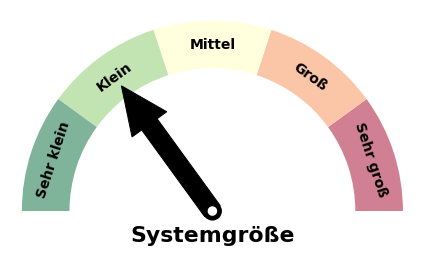

In [11]:
#Systemgröße

#Cypher Abfrage
import pandas as pd

query ="MATCH (t:Type)-[:HAS_SOURCE]->(f), (t)-[:DECLARES]->(m:Method) RETURN sum(m.effectiveLineCount) as loc"
df = pd.DataFrame(graph.run(query).data())

#Visualisierung
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Wedge, Rectangle
import numpy as np


def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

def gauge(labels=['Sehr klein','Klein','Mittel','Groß','Sehr Groß'], \
          colors='jet_r', arrow=1, title='', fname=False): 
    
    """
    some sanity checks first
    
    """
    
    N = len(labels)
    
    if arrow > N: 
        raise Exception("\n\nThe category ({}) is greated than \
        the length\nof the labels ({})".format(arrow, N))
 
    
    """
    if colors is a string, we assume it's a matplotlib colormap
    and we discretize in N discrete colors 
    """
    
    if isinstance(colors, str):
        cmap = cm.get_cmap(colors, N)
        cmap = cmap(np.arange(N))
        colors = cmap[::-1,:].tolist()
    if isinstance(colors, list): 
        if len(colors) == N:
            colors = colors[::-1]
        else: 
            raise Exception("\n\nnumber of colors {} not equal \
            to number of categories{}\n".format(len(colors), N))

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(N)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, title, horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = mid_points[abs(arrow - N)]
    
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

#Analyse
# Hole Wert an 0. Stelle im Dataframe.
loc = df.iloc[0]['loc']

# Errechne Level auf der Grundlage der Anzahl der Quelltextzeilen.
def calculate_level(loc):
    if loc <= 10000:
        level=1
    elif loc <= 50000:
        level=2
    elif loc <= 200000:
        level=3
    elif loc <= 500000:
        level=4
    else:
        level=5
    return(level)

# Erstelle Gauge.
gauge(labels=['Sehr klein','Klein','Mittel','Groß','Sehr groß'], \
        colors='RdYlGn', arrow=calculate_level(loc), title='Systemgröße')

## Testabdeckung

In der Treemap Testabdeckung wird dargestellt, welche Pakete eine niedrige Testabdeckung haben. Die Testabdeckung ist das Verhältnis von den getroffenen Aussagen eines Testdurchlaufs im Verhältnis zu den möglichen Aussagen, die getroffen werden können. Das bedeutet, je höher die Testabdeckung ist, desto mehr eventuell auftauchenden Fehlern konnte vorgebeugt werden. Diese Analy-se ermöglicht es dem Entwickler einzuschätzen, welche Pakete nur wenig getestet wurden und somit geprüft werden müssen. Zusätzlich wird im Titel der Treemap für einen schnelleren Über-blick die gesamte Testabdeckung des Systems angegeben.

In [4]:
#Testabdeckung

#Cypher Abfrage
import pandas as pd

query ="MATCH (p:Jacoco:Package)-[HAS_CLASS]->(c:Jacoco:Class)-[:HAS_METHOD]->(m:Method:Jacoco)-[:HAS_COUNTER]->(t:Counter) WHERE t.type='INSTRUCTION' AND p.name STARTS WITH 'org' RETURN p.name AS package, ((sum(t.covered)*100)/(sum(t.covered)+sum(t.missed)))/100.0 as coverage, sum(t.covered)+sum(t.missed) as loc ORDER BY loc DESC"
df = pd.DataFrame(graph.run(query).data())

#Analyse
# Erzeuge eine neue Spalte color und berechne die entsprechende Farbe in Abhängigkeit zu coverage.
from matplotlib.cm import RdYlGn
from matplotlib.colors import rgb2hex

df['color'] = df['coverage'].apply(lambda x : rgb2hex(RdYlGn(x)))
df.head()
# Berechne den Mittelwert der Spalte coverage und speichere diesen in der Variable coverage.
coverage = df['coverage'].mean()


#Visualisierung ausgeben
# Erstelle Treemap.
import pygal
treemap = pygal.Treemap(height=250, show_legend=False, 
                        value_formatter = lambda x: 'Größe: {} Zeilen '.format(x))
treemap.title = 'Testabdeckung (Prozent bzw. grün=hoch & rot=gering) und Größe (Quelltextzeilen) auf Paketebene (gesamt: ' + str(coverage.round(2) * 100) + ' %)'
for index, row in df.iterrows():
    treemap.add(row['package'],
                [{"value": row['loc'], "label": "Testabdeckung: " + str(row['coverage'] * 100) + " %",
                  "color": row['color']}])
display(HTML(base_html.format(rendered_chart=treemap.render(is_unicode=True))))
 

## Programmierverstöße

Im Radar Chart werden die Art der Programmierverstöße mit ihrer absoluten Anzahl dargestellt. Die Programmierverstöße werden in fünf Kategorien unterteilt. 
Dabei wird aufgezeigt, welche Qualität das Programm hinsichtlich Code Style, Error Prone, Multithreading, Best Practices und Design aufweist.

In [5]:
#Programmierverstöße

#Cypher Abfrage
import pandas as pd

query ="MATCH (:Report)-[:HAS_FILE]->(file:File:Pmd)-[:HAS_VIOLATION]->(violation:Violation) RETURN  violation.ruleSet as category, count(violation.ruleSet) as frequency"
df = pd.DataFrame(graph.run(query).data())

#Analyse
# Hole Werte aus Spalten des Dataframes. Umwandlung dieser Werte in eine Liste.
frequency=df['frequency'].tolist()
category=df['category'].tolist()

#Visualisierung
# Erstelle Radar Chart.
import pygal
radar_chart = pygal.Radar(show_legend=False)
radar_chart.title = 'Programmierverstöße'
radar_chart.x_labels = category
radar_chart.add('', frequency)

display(HTML(base_html.format(rendered_chart=radar_chart.render(is_unicode=True))))

## Entwickler mit den meisten Commits

Im Balkendiagramm Entwickler mit den meisten Commits werden die zehn Entwickler mit den meisten Commits in Abhängigkeit der absoluten Anzahl ihrer Commits dargestellt.
Hier erkennt man, welcher Entwickler den meisten Anteil an dem Entwickeln des Programmes hatte.


In [6]:
#Entwickler

#Cypher Abfrage
import pandas as pd

query ="MATCH (a:Author)-[:COMMITTED]->(c:Commit)-[:CONTAINS_CHANGE]->(:Change)-[:MODIFIES]->(file:File) WHERE NOT c:Merge RETURN a.name as developer, count(distinct c) as commits"
df = pd.DataFrame(graph.run(query).data())

#Analyse
# Sortiere das Dataframe nach der Anzahl der Commits (commits).
df = df.sort_values('commits', ascending=False)

# Extrahiere die ersten zehn Spalten und speichere sie im Dataframe developer_df.
developer_df = df[0:10]
developer_df.head(10)


#Visualisierung

import pygal
bar_chart = pygal.HorizontalBar(show_legend=True, human_readable=True, 
fill=True, legend_at_bottom=True, legend_at_bottom_columns=2)
bar_chart.title = 'Entwickler mit den meisten Commits'
for index, row in developer_df.iterrows():
     bar_chart.add(row['developer'],[{"value": row['commits']}])
display(HTML(base_html.format(rendered_chart=bar_chart.render(is_unicode=True))))


## Größte Methoden

Im Balkendiagramm Größte Methoden werden die zehn Methoden mit den meisten Quelltextzeilen in Abhängigkeit der absoluten Anzahl ihrer Quelltextzeilen dargestellt. Die größte Methode wird somit ermittelt.
Große Methoden sind prädestiniert für Fehler und sollten im Rahmen des Reengineerngs überarbeitet werden, z.B. in kleinere aufgeteilt.

In [7]:
#größte Methoden

#Cypher Abfrage
import pandas as pd

query ="MATCH (t:Type)-[:HAS_SOURCE]->(f), (t)-[:DECLARES]->(m:Method) RETURN DISTINCT t.fqn as type, m.signature as signature,  m.effectiveLineCount as loc, m.cyclomaticComplexity as complexity"
df = pd.DataFrame(graph.run(query).data())

#Analyse

# Sortiere das Dataframe nach der Anzahl der Quelltextzeilen (loc).
df = df.sort_values('loc',ascending=False)
# Extrahiere die Spalten loc, signature und type und speichere sie im Dataframe loc_df.
loc_df = df[['loc','signature','type']][0:10]
loc_df.head(10)


#Visualisierung
# Erstelle Bar Chart für loc.
import pygal
bar_chart = pygal.HorizontalBar(show_legend=True, human_readable=True, fill=True, legend_at_bottom=True, legend_at_bottom_columns=2)
bar_chart.title = 'Größte Methoden'
for index, row in loc_df.iterrows():
    bar_chart.add(row['type'],[{"value": row['loc'], "label": row['signature']}])
display(HTML(base_html.format(rendered_chart=bar_chart.render(is_unicode=True))))

## Komplexeste Methoden
Im Balkendiagramm Komplexeste Methoden werden die zehn Methoden der höchsten Komplexität in Abhängigkeit der absoluten Anzahl ihrer Quelltextzeilen dargestellt. Dabei werden die Anzahl der Rechenschritte /Speicherbedarf betrachtet.


In [8]:
#komplexeste Methoden

#Cypher Abfrage
import pandas as pd

query ="MATCH (t:Type)-[:HAS_SOURCE]->(f), (t)-[:DECLARES]->(m:Method) RETURN t.fqn as type, m.signature as signature,  sum(m.effectiveLineCount) as loc, sum(m.cyclomaticComplexity) as complexity"
df = pd.DataFrame(graph.run(query).data())

#Analyse
# Sortiere das Dataframe nach der zyklomatischen Komplexität (complexity).
df = df.sort_values('complexity',ascending=False)

# Extrahiere die Spalten complexity, signature und type und speichere sie im Dataframe complexity_df.
complexity_df = df[['complexity','signature','type']][0:10]
complexity_df.head(10)


#Visualisierung
import pygal 
bar_chart = pygal.HorizontalBar(show_legend=True, human_readable=True, fill=True, legend_at_bottom=True, legend_at_bottom_columns=2)
bar_chart.title = 'Komplexeste Methoden'
for index, row in complexity_df.iterrows():
    bar_chart.add(row['type'],[{"value": row['complexity'], "label": row['signature']}])
display(HTML(base_html.format(rendered_chart=bar_chart.render(is_unicode=True))))

## Dateitypen
Das vorliegende Kreisdiagramm Dateitypen visualisiert die prozentuale Häufigkeit der benutzten Dateitypen. Dateitypen mit einer absoluten Häufigkeit kleiner gleich 3 werden unter Andere zusammengefasst. Man kann damit das Programm näher kennenlernen und herausfinden, welche Programmiersprache am meisten eingesetzt wurde.

In [9]:
#Dateitypen

#Cypher Abfrage
import pandas as pd

query ="MATCH (f:Git:File) RETURN f.relativePath as relativePath"
df = pd.DataFrame(graph.run(query).data())
#Analyse
# Extrahiere Dateitypen aus Spalte des Dataframes.
datatypes = df['relativePath'].str.rsplit('.', 1).str[1]

# Zähle die Anzahl der Dateitypen und bilde diese in einem Series-Objekt ab.
series = datatypes.value_counts()

# Erzeuge zwei Listen aus dem Series-Objekt.
datatype = list(series.index)
frequency = list(series)

# Erzeuge die Kategorie "andere", in der alle Dateitypen gesammelt werden, die weniger oder genau 20 mal auftauchen.
andere = 0
for wert in frequency[:]:
    index = frequency.index(wert)
    if wert <= 20:
        andere += wert
        datatype.remove(datatype[index])
        frequency.remove(wert)
frequency.append(andere)
datatype.append("andere")

#Visualisierung
import pygal 
pie_chart = pygal.Pie()
pie_chart.title = 'Dateitypen'
for einzelneDateitypen in datatype:
    index= datatype.index(einzelneDateitypen)
    anzahl=frequency[index]
    pie_chart.add(einzelneDateitypen, anzahl)
display(HTML(base_html.format(rendered_chart=pie_chart.render(is_unicode=True))))

## Toxicity Chart
Das Toxicity Chart gibt die giftigste Klasse des Softwaresystems aus. Dazu wird der Giftigkeitsgrad anhand selbst festgelegter Metriken (hier: ClassFanOutComplexity, CyclomaticCom-plexity, MethodLength und ParameterNumber) und deren Schwellenwerte (hier: 30, 10, 30, 6) bestimmt. Der Giftigkeitsgrad wird in einem gestapelten Säulendiagramm veranschaulicht, das die einzelnen Anteile der Metriken, die den Giftigkeitsgrad bestimmen, anzeigen. Anhand dieser Analyse erkennt man schnell Klassen, die Probleme aufweisen können und somit einen hohen Wartungsaufwand verursachen können.

In [10]:
#Cypher Abfrage
import pandas as pd

classfanoutcomplexity_query ="MATCH (c:Type)-[:DEPENDS_ON]->(d:Type) WHERE NOT c.name CONTAINS '$' RETURN DISTINCT c.fqn as Type, count(d) AS ClassFanOutComplexity ORDER BY ClassFanOutComplexity DESC"
classfanoutcomplexity_df = pd.DataFrame(graph.run(classfanoutcomplexity_query).data())

cyclomaticcomplexity_query ="MATCH (c:Type)-[DECLARES]->(m:Method) WHERE NOT c.name CONTAINS '$' AND EXISTS(m.cyclomaticComplexity) RETURN DISTINCT m.signature AS Method, c.fqn AS Type, m.cyclomaticComplexity as CyclomaticComplexity ORDER BY CyclomaticComplexity DESC"
cyclomaticComplexity_df = pd.DataFrame(graph.run(cyclomaticcomplexity_query).data())

methodlength_query ="MATCH (c:Type)-[DECLARES]->(m:Method) WHERE NOT c.name CONTAINS '$' AND EXISTS(m.effectiveLineCount) RETURN DISTINCT m.signature AS Method, c.fqn AS Type, m.effectiveLineCount AS MethodLength ORDER BY MethodLength DESC"
methodLength_df = pd.DataFrame(graph.run(methodlength_query).data())

parameternumber_query ="MATCH (c:Type)-[DECLARES]->(m:Method)-[HAS]->(p:Parameter) WHERE NOT c.name CONTAINS '$' RETURN m.signature AS Method, c.fqn AS Type, count(p) AS ParameterNumber ORDER BY ParameterNumber DESC"
parameterNumber_df = pd.DataFrame(graph.run(parameternumber_query).data())

# Analyse
# Entferne alle Klassen, die weniger als 30 Abhängigkeiten zu anderen Klassen besitzen.
classfanoutcomplexity_df.drop(classfanoutcomplexity_df[classfanoutcomplexity_df['ClassFanOutComplexity'] < 30 ].index , inplace=True)


# Entferne alle Methoden, deren zyklomatische Komplexität kleiner als 10 ist.
cyclomaticComplexity_df.drop(cyclomaticComplexity_df[cyclomaticComplexity_df['CyclomaticComplexity']<10].index, inplace=True)


# Entferne alle Methoden, deren Anzahl der Quelltextzeilen kleiner als 30 ist.
methodLength_df.drop(methodLength_df[methodLength_df['MethodLength'] < 30 ].index , inplace=True)


# Entferne alle Methoden, die weniger als 6 Paramter besitzen.
parameterNumber_df.drop(parameterNumber_df[parameterNumber_df['ParameterNumber'] < 6 ].index , inplace=True)


# Die drei Dataframes mit Methodenmetriken werden zusammengeführt und im Dataframe method_metrics_df abgebildet.
method_metrics_df = pd.merge(cyclomaticComplexity_df, methodLength_df[['Type', 'MethodLength']], how='outer', on = 'Type').merge(parameterNumber_df[['Type', 'ParameterNumber']], how='outer', on = 'Type')


# Fehlende Werte werden auf 0 gesetzt.
method_metrics_df = method_metrics_df.fillna(0)


# Die Dataframes classfanoutcomplexity_df und method_metrics_df werden zusammengeführt.
toxicity_df = pd.merge(classfanoutcomplexity_df, method_metrics_df, how='outer', on = 'Type')

# Fehlende Werte werden auf 0 gesetzt.
toxicity_df= toxicity_df.fillna(0)


# Berechne den Toxicity-Wert für ClassFanOutComplexity.
toxicity_df['ClassFanOutComplexity'] = toxicity_df['ClassFanOutComplexity'].apply(lambda value: value/30)

# Berechne den Toxicity-Wert für CyclomaticComplexity.
toxicity_df['CyclomaticComplexity'] = toxicity_df['CyclomaticComplexity'].apply(lambda value: value/10)

# Berechne den Toxicity-Wert für MethodLength.
toxicity_df['MethodLength'] = toxicity_df['MethodLength'].apply(lambda value: value/30)

# Berechne den Toxicity-Wert für ParameterNumber.
toxicity_df['ParameterNumber'] = toxicity_df['ParameterNumber'].apply(lambda value: value/6)

# Erzeuge die Spalte ToxicityScore und berechne die Zeilensumme aus ClassFanOutComplexity, CyclomaticComplexity, MethodLength und ParameterNumber.
toxicity_df['ToxicityScore'] = toxicity_df.ClassFanOutComplexity + toxicity_df.CyclomaticComplexity + toxicity_df.MethodLength + toxicity_df.ParameterNumber

# Sortiere alle Werte absteigend nach dem ToxicityScore.
toxicity_df = toxicity_df.sort_values('ToxicityScore', ascending=False)

import pygal
stacked_bar_chart = pygal.StackedBar(show_legend=True, human_readable=True, fill=False, x_label_rotation=90, truncate_label=-1, truncate_legend=-1)
stacked_bar_chart.title = 'Toxicity Chart'
stacked_bar_chart.x_labels = toxicity_df['Type'].tolist()
stacked_bar_chart.add('ClassFanOutComplexity', toxicity_df['ClassFanOutComplexity'].tolist())
stacked_bar_chart.add('CyclomaticComplexity', toxicity_df['CyclomaticComplexity'].tolist())
stacked_bar_chart.add('MethodLength', toxicity_df['MethodLength'].tolist())
stacked_bar_chart.add('ParameterNumber', toxicity_df['ParameterNumber'].tolist())
display(HTML(base_html.format(rendered_chart=stacked_bar_chart.render(is_unicode=True))))
